# Lab 4 - Algorytmy Grupowania Danych

In [15]:
# Imports
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, DBSCAN
from ydata_profiling import ProfileReport
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
raw_df = pd.read_csv("../dbs/abalone/abalone.data", header=None)
raw_df.head()

,0,1,2,3,4,5,6,7,8
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


## Kolumny w zbiorze danych

Name / Data Type / Measurement Unit / Description

Sex / nominal / -- / M, F, and I (infant) 
Length / continuous / mm / Longest shell measurement
Diameter	/ continuous / mm / perpendicular to length
Height / continuous / mm / with meat in shell
Whole weight / continuous / grams / whole abalone
Shucked weight / continuous	 / grams / weight of meat
Viscera weight / continuous / grams / gut weight (after bleeding)
Shell weight / continuous / grams / after being dried
Rings / integer / -- / +1.5 gives the age in years


In [3]:

# assign column names
columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
raw_df.columns = columns
raw_df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [4]:
# Podział danych na zbiór treningowy i testowy
X = raw_df
train_data, test_data = train_test_split(X, test_size=0.2, random_state=42)

df = train_data.copy()

In [5]:
# AutoEDA
profile = ProfileReport(df, title="Abalone dataset EDA", explorative=True)
profile.to_file("abalone_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/ydata_profiling/model/correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'I'')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

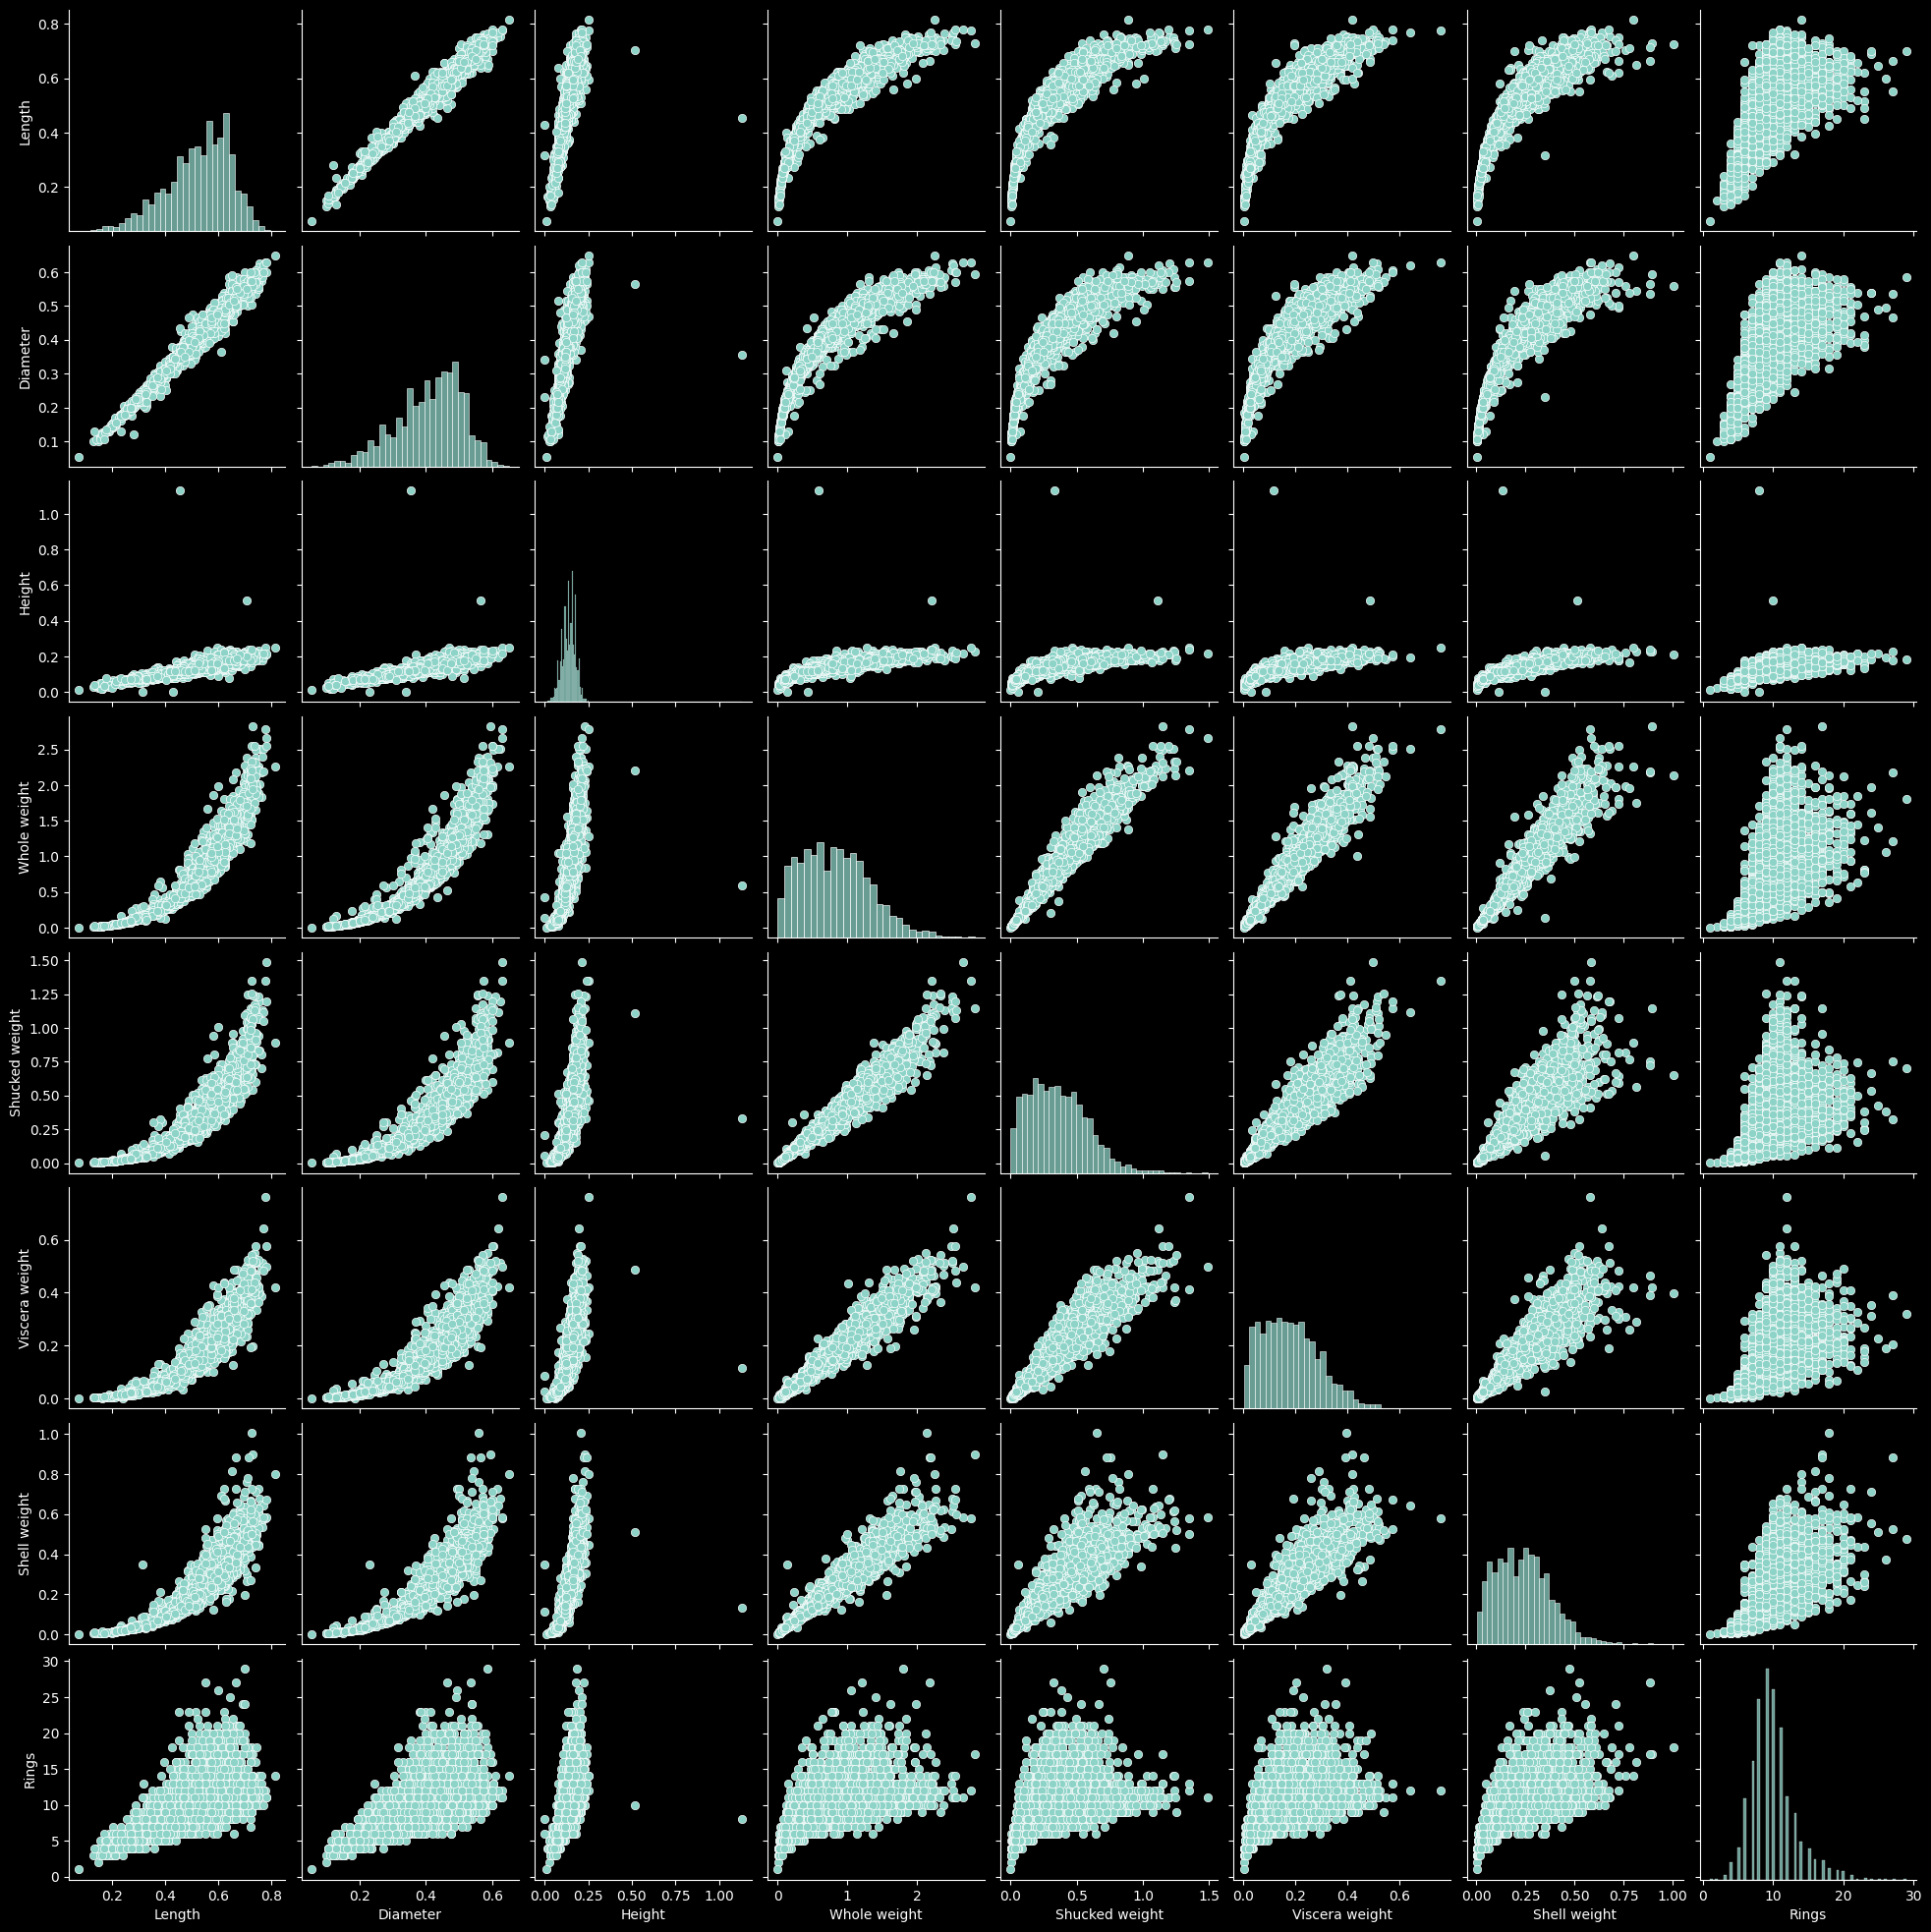

In [6]:
sns.pairplot(df)
plt.show()

## Wnioski EDA
Super zbiór, nie ma brakujących danych, powtarzających się wierszy itp.

Jedna kolumna kategoryczna: Sex

In [7]:
# Konwersja kategorii 'Sex' na zmienne numeryczne
df = pd.get_dummies(df, columns=['Sex'])

In [8]:
# Standaryzacja danych
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

data_scaled = pd.DataFrame(scaled_features, columns=df.columns[:])

In [9]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
iso_forest.fit(data_scaled)

# Predykcja outlierów
outliers_pred = iso_forest.predict(data_scaled)

# Oznaczanie outlierów w zbiorze danych
data_scaled['outlier'] = outliers_pred
outliers = data_scaled[data_scaled['outlier'] == -1]

clean_data = data_scaled[data_scaled['outlier'] == 1]

print("Wykryto outlierów:", len(outliers))
print("Liczba rekordów po usunięciu outlierów:", clean_data.shape[0])


Wykryto outlierów: 334
Liczba rekordów po usunięciu outlierów: 3007


In [10]:
clean_data.drop('outlier', axis=1, inplace=True)
clean_data.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M,outlier
0,0.210175,0.369725,-0.347950,-0.323164,-0.325407,-0.405130,-0.212132,0.329098,-0.67464,1.451863,-0.758909,1
1,-0.419444,-0.542386,-0.936082,-0.665985,-0.480126,-0.820932,-0.712419,-0.606395,-0.67464,1.451863,-0.758909,1
3,-2.098428,-2.113245,-1.759467,-1.453355,-1.363597,-1.533734,-1.462848,-0.918227,-0.67464,1.451863,-0.758909,1
4,-0.251546,-0.289022,-0.112697,-0.409632,-0.437522,-0.350299,-0.176398,0.640929,-0.67464,-0.688770,1.317680,1
5,-0.167597,-0.289022,-0.465577,-0.481859,-0.453219,-0.341161,-0.426541,-0.918227,-0.67464,1.451863,-0.758909,1


# Uruchomienie algorytmów grupowania

In [26]:
# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(clean_data)

In [27]:

# Ewaluacja K-Means
print("K-Means Silhouette Score: ", silhouette_score(clean_data, kmeans_labels))
print("K-Means Davies-Bouldin Score: ", davies_bouldin_score(clean_data, kmeans_labels))
print("K-Means Calinski-Harabasz Score: ", calinski_harabasz_score(clean_data, kmeans_labels))

K-Means Silhouette Score:  0.43879294784326456
K-Means Davies-Bouldin Score:  0.9019672062567622
K-Means Calinski-Harabasz Score:  2597.432438430803


In [28]:

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(clean_data)

In [29]:

# Ewaluacja DBSCAN
print("DBSCAN Silhouette Score: ", silhouette_score(clean_data, dbscan_labels))
print("DBSCAN Davies-Bouldin Score: ", davies_bouldin_score(clean_data, dbscan_labels))
print("DBSCAN Calinski-Harabasz Score: ", calinski_harabasz_score(clean_data, dbscan_labels))


DBSCAN Silhouette Score:  0.04447446728591927
DBSCAN Davies-Bouldin Score:  1.0035548028565422
DBSCAN Calinski-Harabasz Score:  358.772105658578


/var/folders/ld/46j6jly10md36dbxgn_h72br0000gn/T/ipykernel_64994/1284046835.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual_data['KMeans_Labels'] = kmeans_labels
/var/folders/ld/46j6jly10md36dbxgn_h72br0000gn/T/ipykernel_64994/1284046835.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual_data['DBSCAN_Labels'] = dbscan_labels


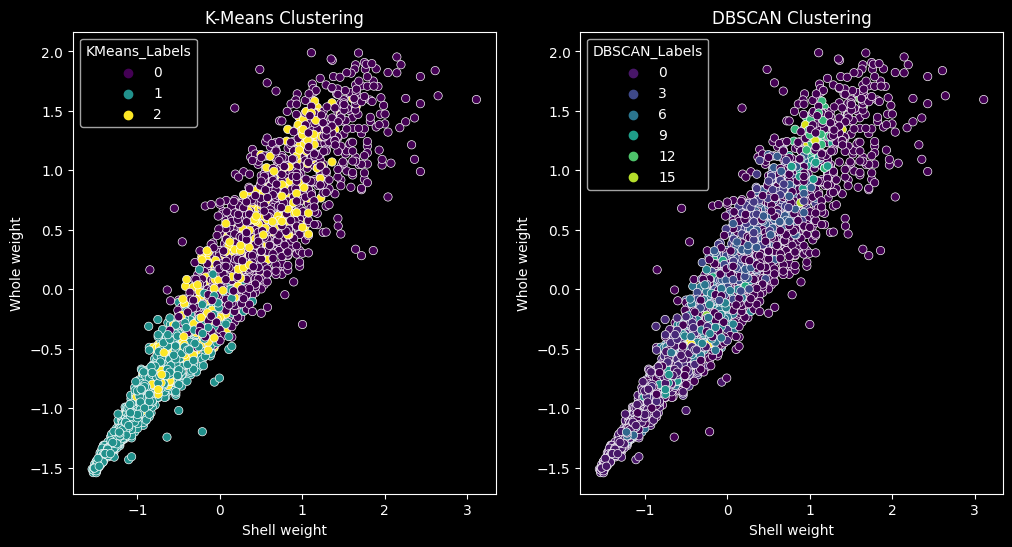

In [30]:
# Wybór zmiennych do wizualizacji
visual_data = clean_data
visual_data['KMeans_Labels'] = kmeans_labels
visual_data['DBSCAN_Labels'] = dbscan_labels

# Wizualizacja dla K-Means
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=visual_data, x='Shell weight', y='Whole weight', hue='KMeans_Labels', palette='viridis')
plt.title('K-Means Clustering')

# Wizualizacja dla DBSCAN
plt.subplot(1, 2, 2)
sns.scatterplot(data=visual_data, x='Shell weight', y='Whole weight', hue='DBSCAN_Labels', palette='viridis')
plt.title('DBSCAN Clustering')

plt.show()


/var/folders/ld/46j6jly10md36dbxgn_h72br0000gn/T/ipykernel_64994/937309158.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['PCA1'] = pca_result[:, 0]
/var/folders/ld/46j6jly10md36dbxgn_h72br0000gn/T/ipykernel_64994/937309158.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['PCA2'] = pca_result[:, 1]


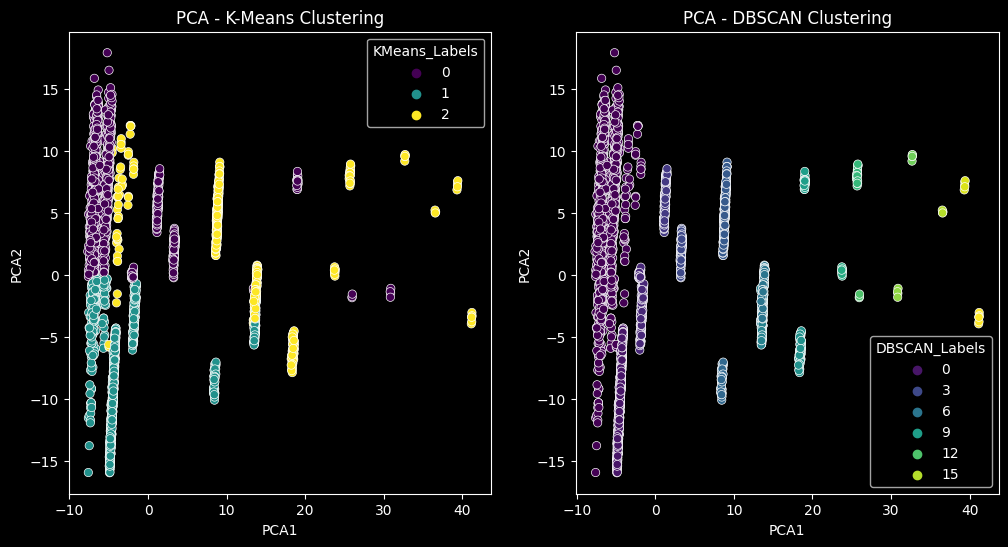

In [37]:
# Redukcja wymiarowości
pca = PCA(n_components=2)
pca_result = pca.fit_transform(clean_data)

clean_data['PCA1'] = pca_result[:, 0]
clean_data['PCA2'] = pca_result[:, 1]

# Wizualizacja PCA dla K-Means
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=clean_data['PCA1'], y=clean_data['PCA2'], hue=visual_data['KMeans_Labels'], palette='viridis')
plt.title('PCA - K-Means Clustering')

# Wizualizacja PCA dla DBSCAN
plt.subplot(1, 2, 2)
sns.scatterplot(x=clean_data['PCA1'], y=clean_data['PCA2'], hue=visual_data['DBSCAN_Labels'], palette='viridis')
plt.title('PCA - DBSCAN Clustering')

plt.show()


# Analiza hiperparametrów

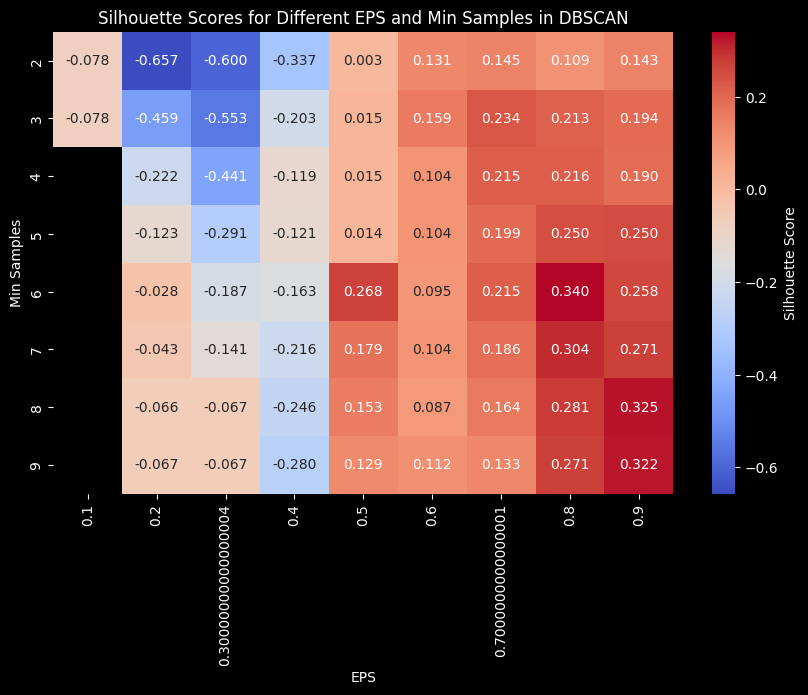

In [39]:
# Testowanie różnych wartości eps i min_samples
eps_values = np.arange(0.1, 1.0, 0.1)
min_samples_values = range(2, 10)
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(clean_data.drop(['Rings'], axis=1))
        if len(set(labels)) > 1:  # Silhouette score is only valid if there are more than one cluster
            silhouette_avg = silhouette_score(clean_data.drop(['Rings'], axis=1), labels)
            results.append((eps, min_samples, silhouette_avg))

# Convert results to DataFrame for easier handling
results_df = pd.DataFrame(results, columns=['eps', 'min_samples', 'silhouette_score'])

# Pivot table for better visualization
pivot_table = results_df.pivot(index='min_samples', columns='eps', values='silhouette_score')

# Heatmap of the results
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap='coolwarm', cbar_kws={'label': 'Silhouette Score'})
plt.title('Silhouette Scores for Different EPS and Min Samples in DBSCAN')
plt.xlabel('EPS')
plt.ylabel('Min Samples')
plt.show()
